# Signature Detection Using YOLOv9

In this notebook, we worked on detecting and labeling a signature in an image. The detected signature is highlighted with a bounding box and labeled with a confidence score. This task involves techniques similar to object detection, where we identify specific objects within an image.

### What is YOLO?
YOLO (You Only Look Once) is a real-time object detection model known for its speed and accuracy. It treats object detection as a single regression problem, predicting bounding boxes and class probabilities directly from the image in one pass through the network.

Key features of YOLO's architecture:
- **Grid-based Predictions**: The image is divided into a grid, and each grid cell predicts bounding boxes and class probabilities.
- **Unified Architecture**: Unlike traditional methods that involve separate steps for region proposal and classification, YOLO combines these into a single neural network.
- **Speed and Efficiency**: YOLO can process images at a very high frame rate, making it suitable for real-time applications.

### Fine-Tuning for Signature Detection
Fine-tuning involves training a pre-trained YOLO model on a custom dataset, adapting it to a new task—in this case, detecting signatures. By providing labeled examples of signatures, the model learns the specific features and patterns to identify them accurately. This is achieved by:
1. **Custom Dataset Preparation**: Collecting and annotating images containing signatures. We did this step using Roboflow tool. Here is the [https://app.roboflow.com/smart-conseil-lvw6i/signature_detector/browse?queryText=&pageSize=50&startingIndex=0&browseQuery=true](#).

2. **Transfer Learning**: Using a pre-trained YOLO model to leverage its learned features.
3. **Optimization**: Adjusting hyperparameters to achieve better performance on the new task.

The result is a specialized YOLO model capable of detecting signatures with high precision, as demonstrated in this notebook.


## Before we start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue Dec  3 09:57:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Clone and Install The model Weights and Architecture

In [3]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 325, done.
remote: Total 325 (delta 0), reused 0 (delta 0), pack-reused 325 (from 1)
Receiving objects: 100% (325/325), 2.25 MiB | 5.30 MiB/s, done.
Resolving deltas: 100% (162/162), done.
/content/yolov9
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.0 MB/s eta 0:00:00


**NOTE:** Let's install the [`roboflow`](https://pypi.org/project/roboflow) package, which we will use to download our dataset from [Roboflow Universe](https://universe.roboflow.com/).

In [4]:
!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00


## Download model weights

**NOTE:** In the YOLOv9 paper, versions `yolov9-s` and `yolov9-m` are also mentioned, but the weights for these models are not yet available in the YOLOv9 [repository](https://github.com/WongKinYiu/yolov9).

In [5]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [6]:
!ls -la {HOME}/weights

total 402444
drwxr-xr-x 2 root root      4096 Dec  3 09:57 .
drwxr-xr-x 1 root root      4096 Dec  3 09:57 ..
-rw-r--r-- 1 root root  51508261 Feb 18  2024 gelan-c.pt
-rw-r--r-- 1 root root 117203713 Feb 18  2024 gelan-e.pt
-rw-r--r-- 1 root root 103153312 Feb 18  2024 yolov9-c.pt
-rw-r--r-- 1 root root 140217688 Feb 18  2024 yolov9-e.pt


## Download The Fine-Tuning Data that we prepared in Roboflow


## Fine-Tuned Dataset for Signature Detection

To fine-tune the YOLO model for signature detection, we collected and annotated a custom dataset using Roboflow. The dataset was specifically prepared to replicate the environment of scanned complaint images that the model will work on.

### Dataset Overview
- **Total Images Before Augmentation**: 1950 labeled signature images.
- **Total Images After Augmentation**: 4980 images.
- **Dataset Split**:
  - **Training Set**: 4545 images (91%)
  - **Validation Set**: 184 images (4%)
  - **Test Set**: 251 images (5%)

### Preprocessing Steps
- **Auto-Orient**: Ensured all images have a consistent orientation.
- **Resize**: Images were resized to 640x640 to standardize input dimensions.

### Data Augmentation
To enhance the robustness of the model and simulate the real-world conditions of scanned images, we applied the following augmentations:
- **Flipping**: Horizontal flips.
- **Rotations**: 90° clockwise, counterclockwise, and upside down.
- **Shearing**: ±10° horizontal and vertical shearing.
- **Grayscale Conversion**: Applied to 25% of images to mimic black-and-white scanned documents.
- **Saturation Adjustments**: Varying between -32% and +32%.
- **Blurring**: Up to 1.4px to simulate low-quality scans.
- **Noise Addition**: Up to 2.24% of pixels were altered to mimic real-world imperfections.

### Outputs per Training Example
Each training image produced 3 augmented versions, significantly increasing the diversity of training samples and improving the model's ability to generalize to unseen data.

This dataset serves as a robust foundation for training the YOLO model, ensuring it performs effectively in detecting signatures from scanned complaint documents.


**NOTE:** Using this dog image we are just testing the base model performance before any fine tuning

In [7]:
!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/dog.jpeg

In [8]:
SOURCE_IMAGE_PATH = f"{HOME}/dog.jpeg"

## Detection with pre-trained COCO model

### gelan-c

In [9]:
!python detect.py --weights {HOME}/weights/gelan-c.pt --conf 0.1 --source {HOME}/data/dog.jpeg --device 0

detect: weights=['/content/weights/gelan-c.pt'], source=/content/data/dog.jpeg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only`

**NOTE:** By default, the results of each subsequent inference sessions are saved in `{HOME}/yolov9/runs/detect/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

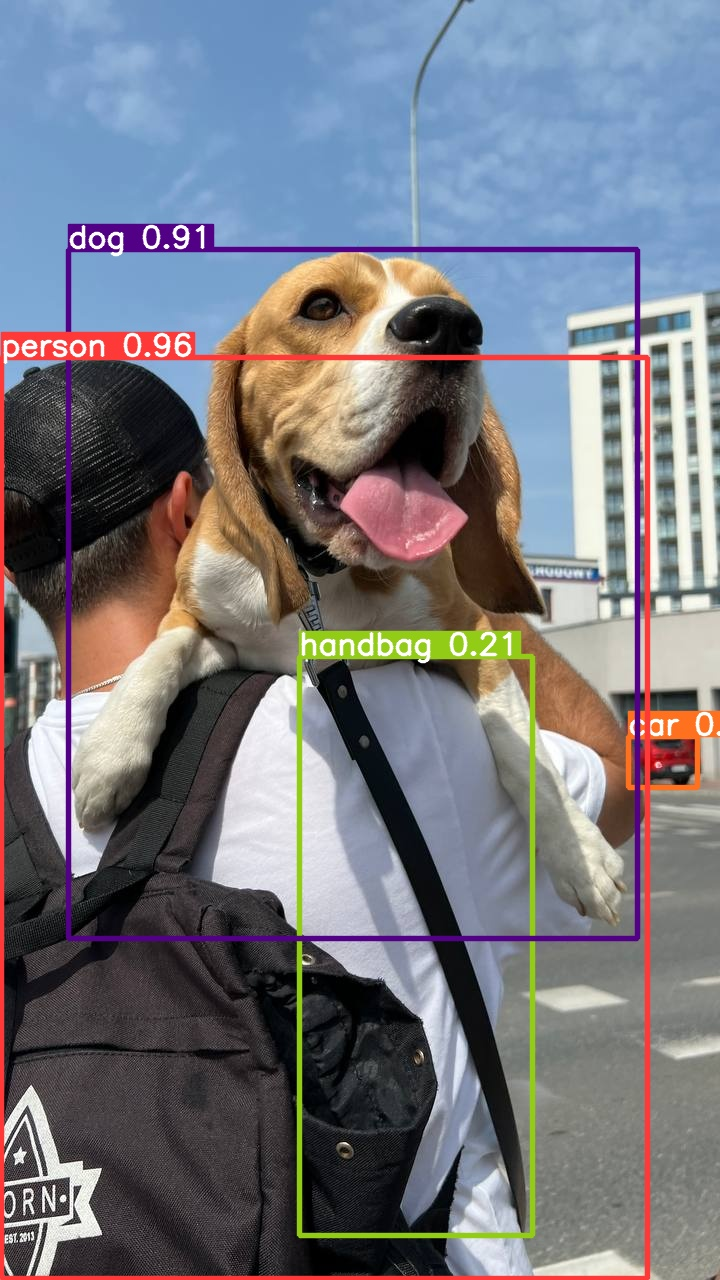

In [10]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/detect/exp/dog.jpeg", width=600)

## yolov9-e

In [11]:
!python detect.py --weights {HOME}/weights/yolov9-e.pt --conf 0.1 --source {HOME}/data/dog.jpeg --device 0

detect: weights=['/content/weights/yolov9-e.pt'], source=/content/data/dog.jpeg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only

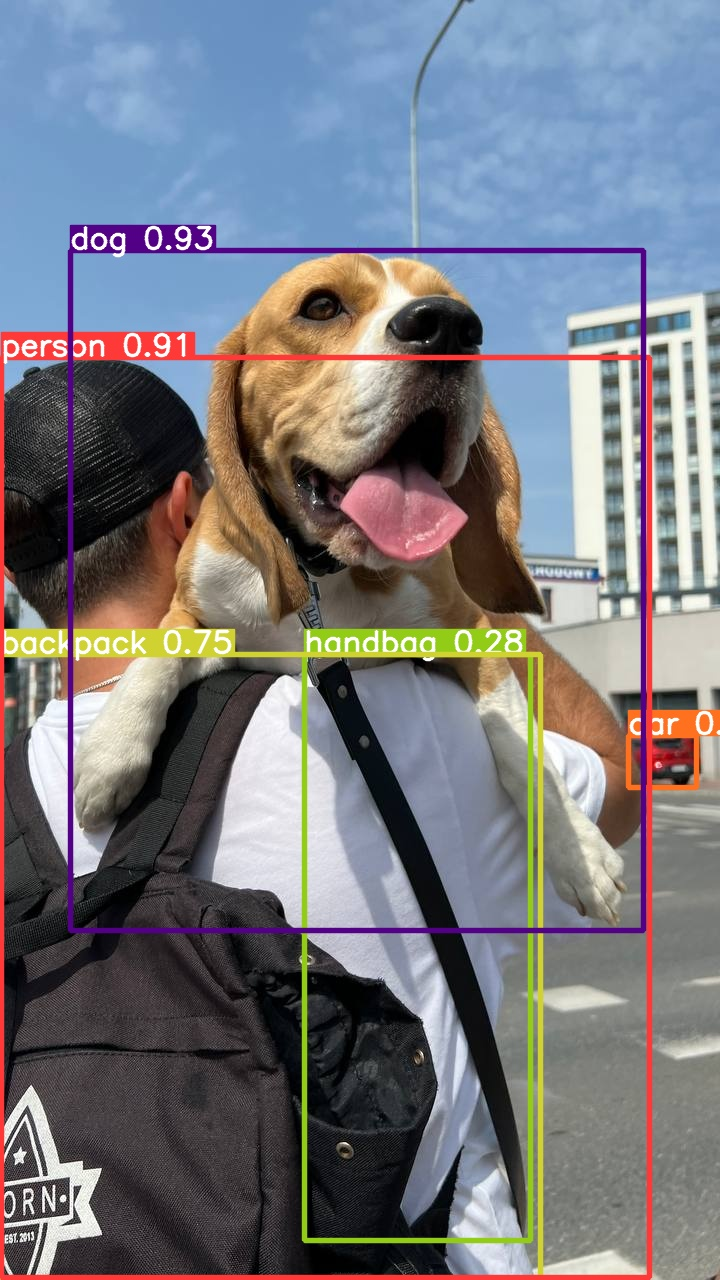

In [12]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/detect/exp2/dog.jpeg", width=600)

## Authenticate and Download the Dataset

**NOTE:** The dataset must be saved inside the `{HOME}/yolov9` directory, otherwise, the training will not succeed.

In [13]:
%cd {HOME}/yolov9

/content/yolov9


**NOTE:** In this tutorial, I will use the [football-players-detection](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc) dataset. Feel free to replace it with your dataset in YOLO format or use another dataset available on [Roboflow Universe](https://universe.roboflow.com). Additionally, if you plan to deploy your model to Roboflow after training, make sure you are the owner of the dataset and that no model is associated with the version of the dataset you are going to training on.

In [14]:
import roboflow
from roboflow import Roboflow
rf = Roboflow(api_key=".....") # I removed my personal roboflow key here but the collected and labled dataset is public you still can consult it
project = rf.workspace("smart-conseil-lvw6i").project("signature_detector")
version = project.version(1)
dataset = version.download("yolov9")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Signature_detector-1 in yolov9:: 100%|██████████| 9932/9932 [00:02<00:00, 4373.56it/s]


## Train Custom Model

In [18]:
# Change the current working directory to the YOLOv9 project directory.
%cd {HOME}/yolov9

# Run the training script for the YOLOv9 model.
!python train.py \
    # Set the batch size to 16 (number of images processed at a time).
    --batch 16 \
    # Set the number of training epochs to 25 (one epoch is one pass through the entire dataset).
    --epochs 25 \
    # Specify the input image size to be 640x640 pixels.
    --img 640 \
    # Use GPU device 0 for training. If you have multiple GPUs, you can specify others.
    --device 0 \
    # Minimum number of items required in a batch for training. Set to 0 to allow all batches.
    --min-items 0 \
    # Close mosaic augmentation after 15 epochs (mosaic augmentation is a technique to merge images for better generalization).
    --close-mosaic 15 \
    # Provide the path to the dataset configuration file (data.yaml).
    --data {dataset.location}/data.yaml \
    # Load pre-trained weights from the specified checkpoint (gelan-c.pt).
    --weights {HOME}/weights/gelan-c.pt \
    # Provide the model architecture configuration file (gelan-c.yaml).
    --cfg models/detect/gelan-c.yaml \
    # Use a specific set of hyperparameters for training (hyp.scratch-high.yaml).
    --hyp hyp.scratch-high.yaml


/content/yolov9
2024-12-03 10:01:44.688487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 10:01:44.708599: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 10:01:44.714496: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 10:01:44.728557: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 10:01:46.088931: W

## Examine Training Results

**NOTE:** By default, the results of each subsequent training sessions are saved in `{HOME}/yolov9/runs/train/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

In [19]:
!ls {HOME}/yolov9/runs/train/exp/

events.out.tfevents.1733219925.9bdacac3bceb.4802.0  hyp.yaml  opt.yaml	weights


## Model Results Analysis

### Confusion Matrix
The confusion matrix indicates the model's performance in distinguishing between the two classes: **"signature"** and **"background"**. Key observations:
- **True Positive Rate (Signature)**: The model successfully identified 95% of the signature samples as signatures, demonstrating strong detection capabilities.
- **False Negative Rate (Signature)**: About 5% of signatures were missed and classified as background, which suggests slight room for improvement in recall.
- **False Positive Rate**: No background samples were misclassified as signatures, which is a positive indicator for precision.

### Training Metrics
The training metrics provide insights into the model's learning progress over epochs. Key takeaways:
1. **Loss Trends**:
   - **Training Loss (box, classification, DFL)**: The training loss steadily decreased over epochs, indicating that the model effectively learned to predict bounding boxes and classify regions.
   - **Validation Loss**: Validation loss followed a similar decreasing trend, confirming that the model generalizes well to unseen data.

2. **Precision and Recall**:
   - Precision and recall both improved over time, stabilizing at values above 90%, which is indicative of a well-trained model with balanced performance across detecting true positives and avoiding false positives.

3. **Mean Average Precision (mAP)**:
   - **mAP@0.5**: The model achieved over 90%, showcasing its ability to detect objects with high confidence.
   - **mAP@0.5:0.95**: Stabilized around 80%, reflecting consistent performance across varying Intersection over Union (IoU) thresholds.

### Conclusion
The YOLO model performed exceptionally well for the task of signature detection, with high precision, recall, and mAP scores. While the results are promising, slight improvements can be made to further reduce false negatives. Additional training with diverse and challenging samples, along with hyperparameter tuning, could push the model's performance even higher.


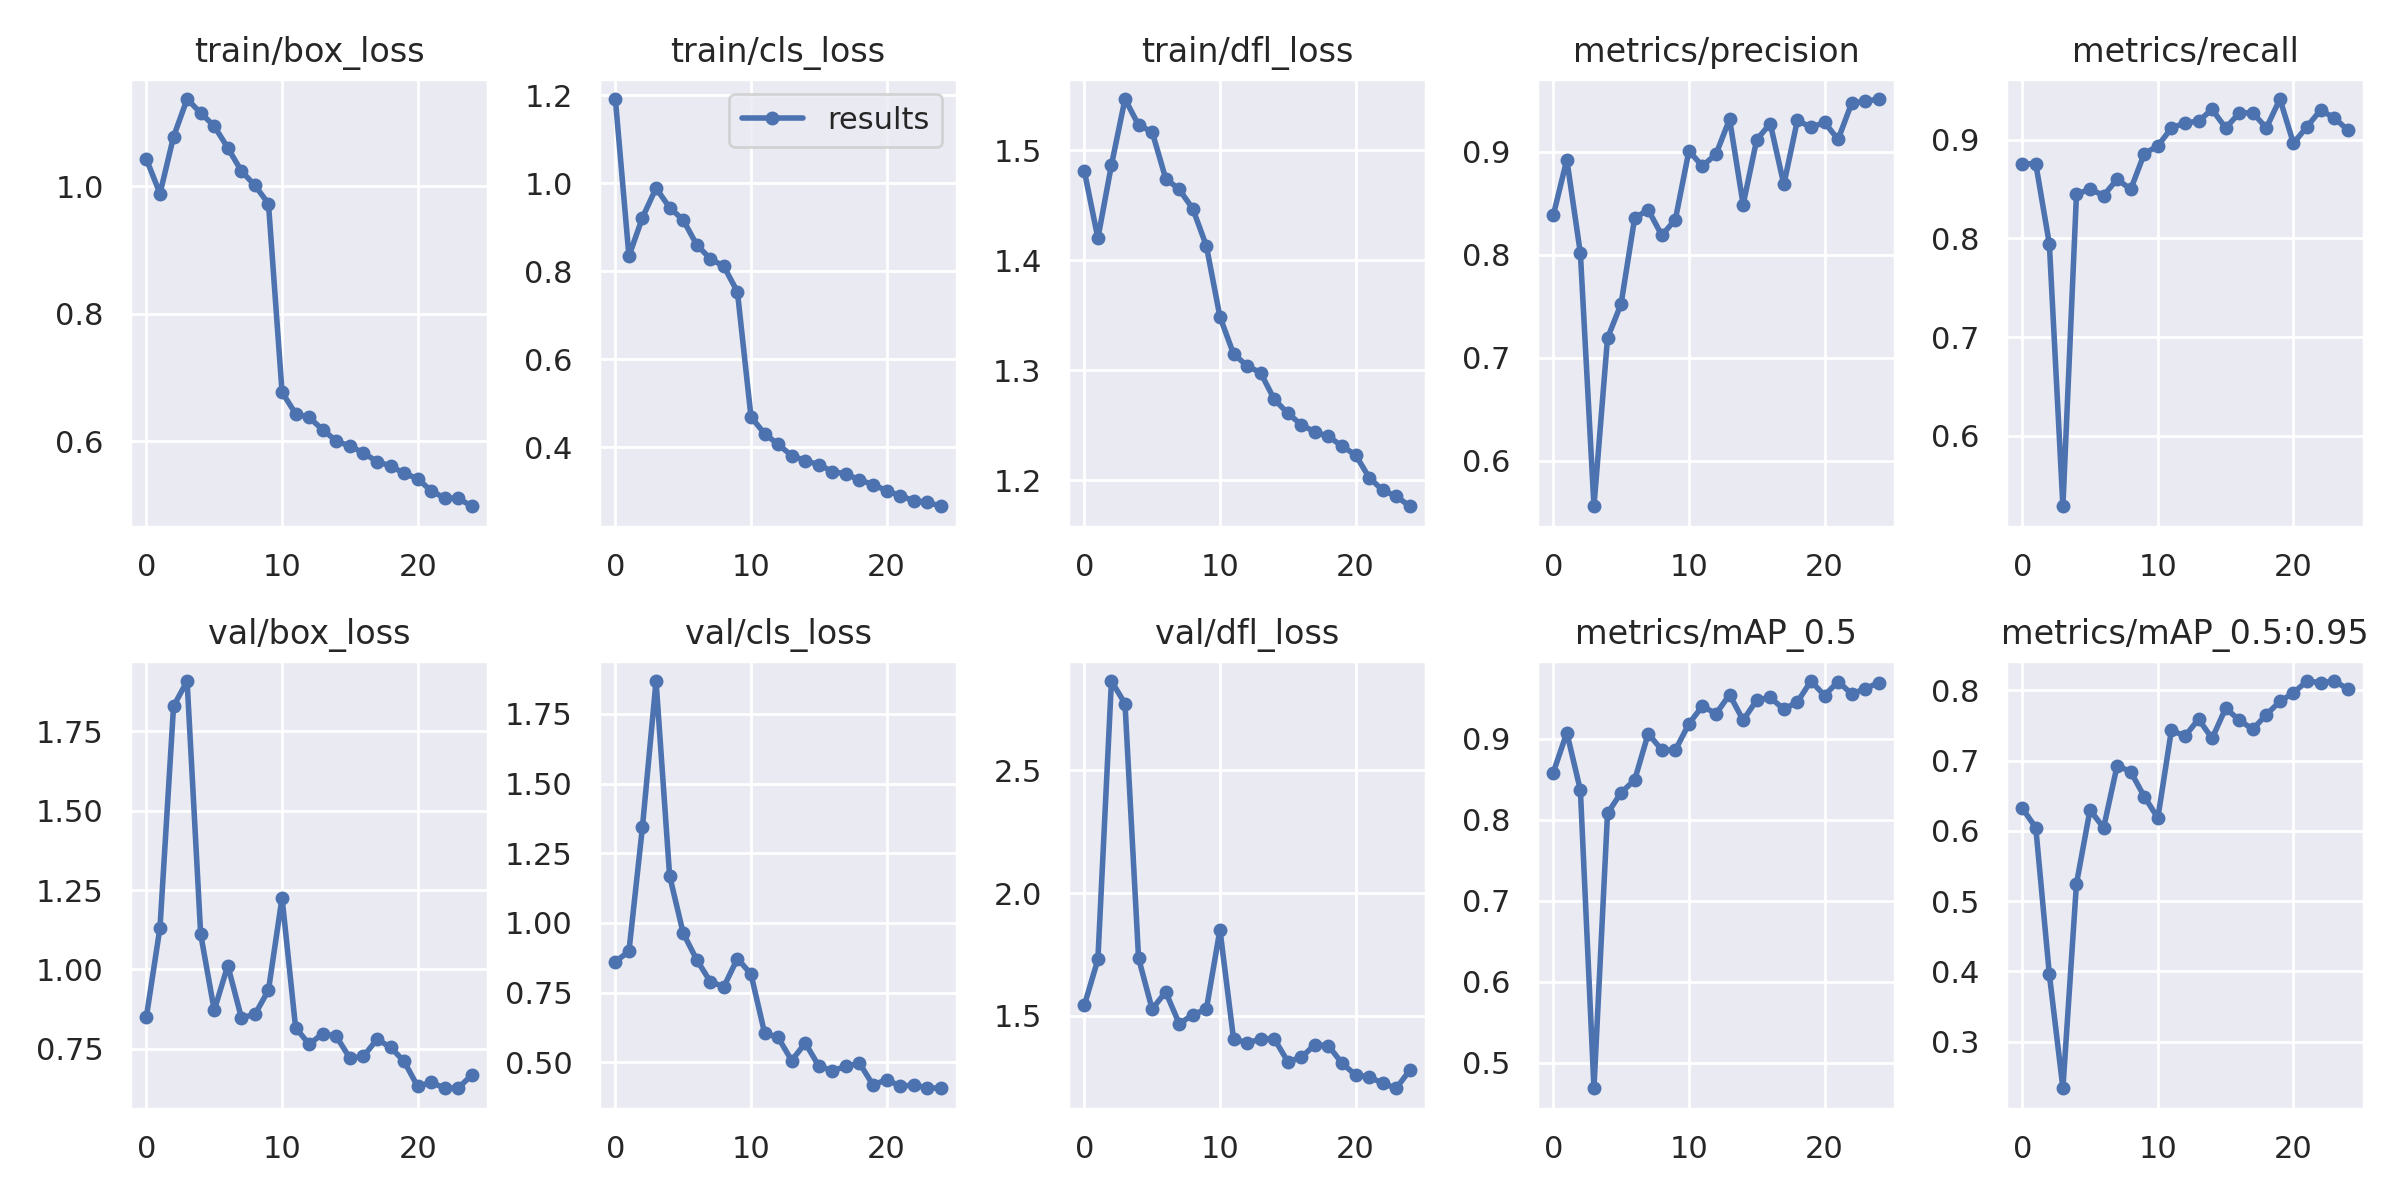

In [22]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp2/results.png", width=1000)

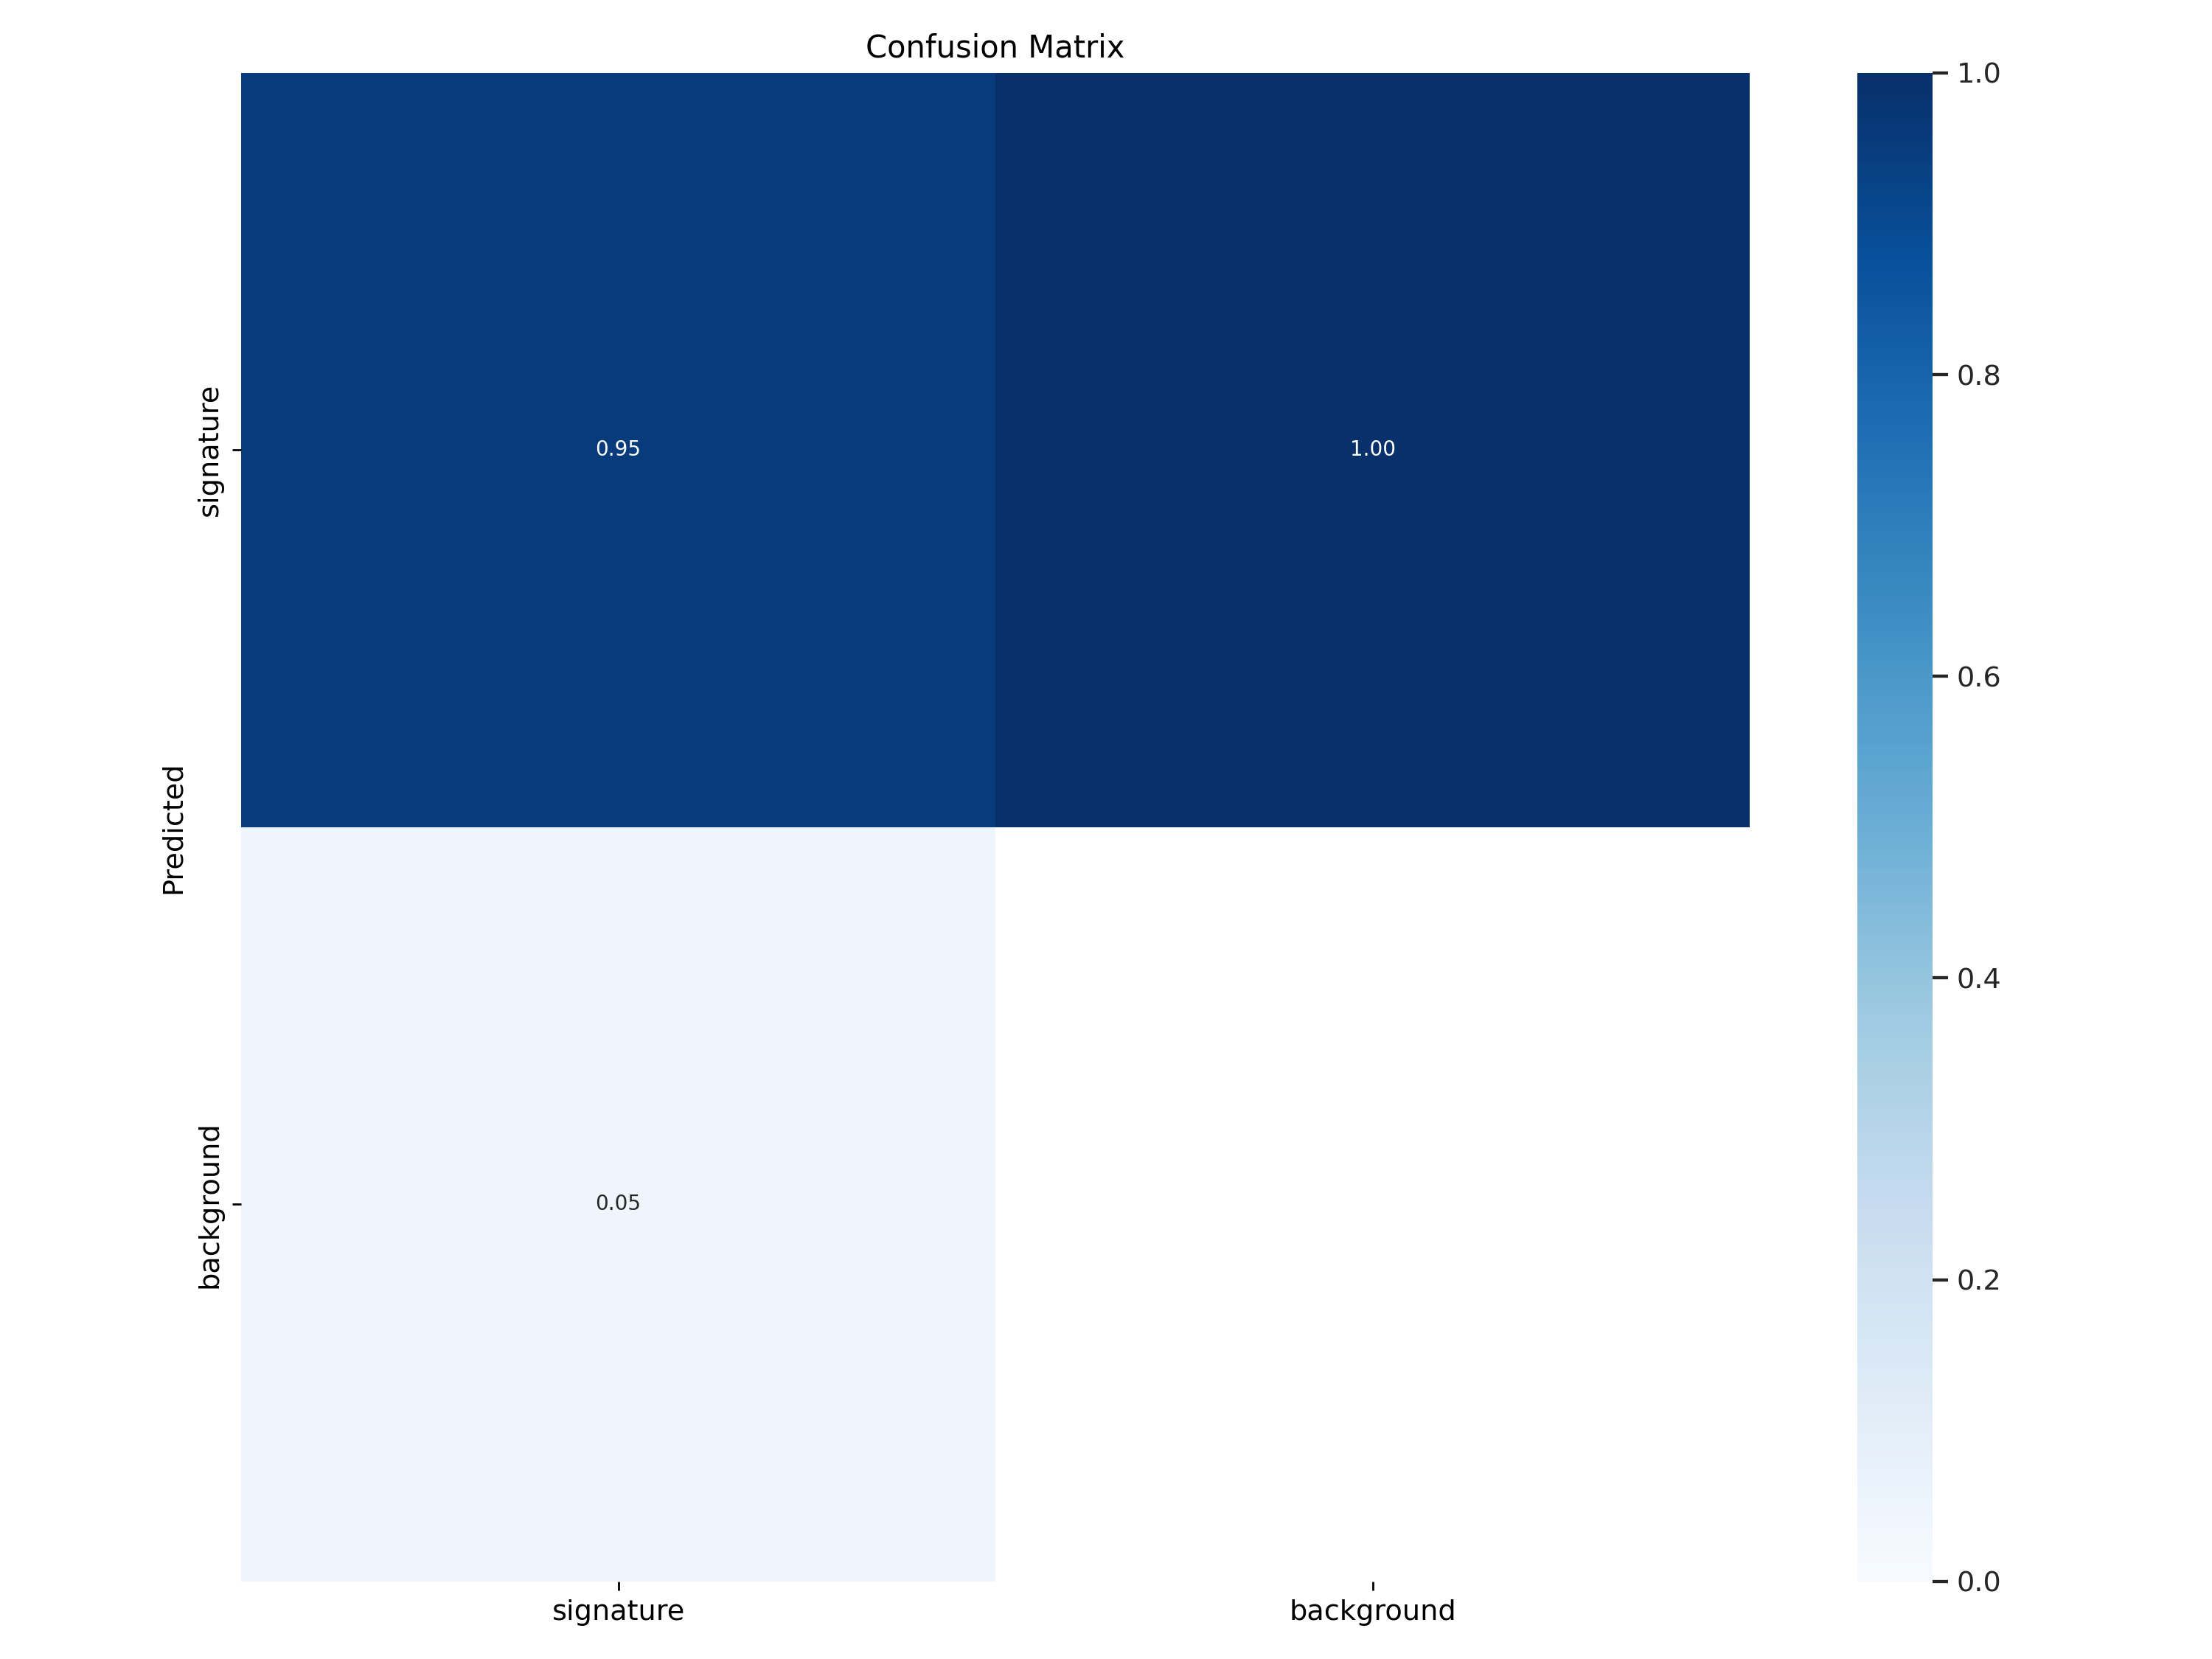

In [23]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp2/confusion_matrix.png", width=1000)

## Validate Custom Model

In [26]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov9/runs/train/exp2/weights/best.pt

/content/yolov9
val: data=/content/yolov9/Signature_detector-1/data.yaml, weights=['/content/yolov9/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits t

## Inference with Custom Model

In [27]:
!python detect.py \
--img 1280 --conf 0.1 --device 0 \
--weights {HOME}/yolov9/runs/train/exp2/weights/best.pt \
--source {dataset.location}/test/images

detect: weights=['/content/yolov9/runs/train/exp2/weights/best.pt'], source=/content/yolov9/Signature_detector-1/test/images, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a futu

In [41]:
!python detect.py \
--img 1280 --conf 0.1 --device 0 \
--weights /content/yolov9/runs/train/exp2/weights/best.pt \
--source /content/data/sig.png


detect: weights=['/content/yolov9/runs/train/exp2/weights/best.pt'], source=/content/data/sig.png, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default val

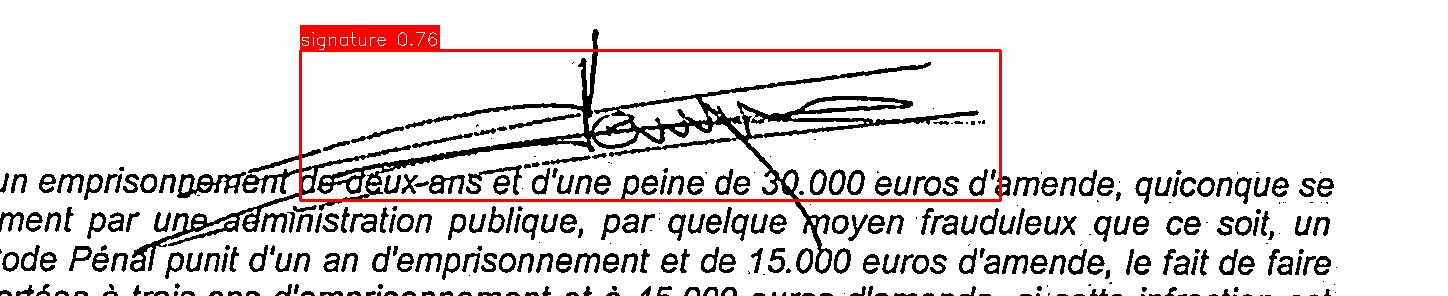

In [43]:
from IPython.display import Image, display

# Path to the image
image_path = "/content/yolov9/runs/detect/exp5/sig.jpg"

# Display the image in the notebook
display(Image(filename=image_path))


**NOTE:** Just like behore, the inference results have been saved in the appropriate directory inside `{HOME}/yolov9/runs/detect/`. Let's examine few of those results.

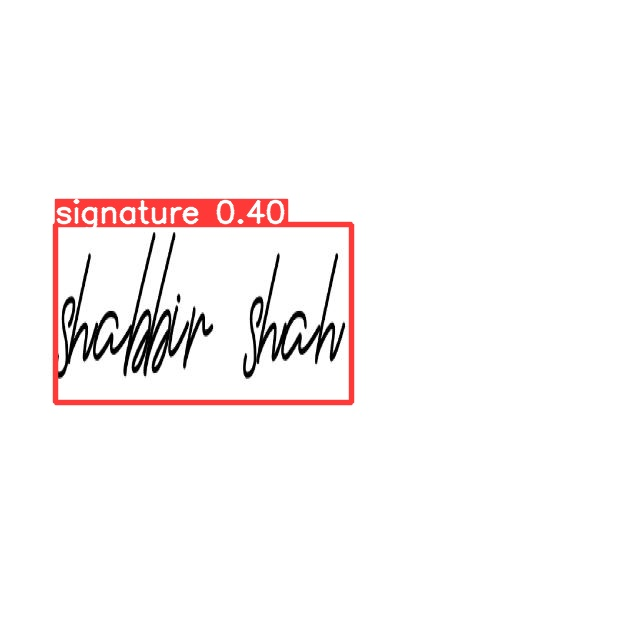

In [46]:
import glob

from IPython.display import Image, display

for image_path in glob.glob(f'/content/yolov9/runs/detect/exp3/index-21-_png.rf.ffad1840a62dba3f4e99f12a592b0b37.jpg')[:2]:
      display(Image(filename=image_path, width=600))
